## Pre Work
### Imports, set sns style etc

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
#sns.set_theme()
from pprint import pprint

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from sklearn.decomposition import PCA

#Setting styles for sns
sns.set_theme(context="notebook", style="darkgrid",font_scale=1.2, rc={"lines.linewidth": 2.5})
#sns.set_style('darkgrid')

### Function and Class Declarations

In [2]:
# Graphing functions

#combined plot for box and hist
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    # boxplot will be created and a star will indicate the mean value of the column
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') 
    sns.histplot(feature, kde=False, ax=ax_hist2, bins=bins,palette="winter") if bins else \
    sns.histplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

def show_values_on_bars(axs, decimals=False):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if decimals:
                value = '{:.2f}'.format(p.get_height())
            else:
                value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

#Modelling clusters in 2d space
def showClustersIn2D(model, df, title='Cluster Plot', ax=None, centroid_size=40, point_size=15):
    '''Takes in a clustering model, a dataframe and plots the points in 2d using PCA to project the 
    n dimensional dataset onto 2D. Can also optionally pass axes if using subplots, custom title and 
    sizes for points and centroids
    model: clustering model which must have fit_predict and cluster_centers_
    '''
    model.fit_predict(df)
    x = model.cluster_centers_
    pca2 = PCA(n_components=2)
    z=np.append(np.asarray(df),x,axis=0)
    z2 = pca2.fit_transform(z)
    zdf = pd.DataFrame(z2, columns = ['x','y'])
    labels = np.append(model.labels_,['Centroids']*3)
    #labels
    sizes={'Centroids':centroid_size}
    for a in model.labels_:
        sizes[str(a)]=point_size
    #print(sizes)


    zdf['clusters'] = labels
    plt.suptitle(title)
    if ax==None:
        kmeansclusterplot = sns.scatterplot(data = zdf, x=zdf.x, y = zdf.y, hue=zdf.clusters, \
                                            size=zdf.clusters, sizes=sizes)
    else:
        kmeansclusterplot = sns.scatterplot(data = zdf, x=zdf.x, y = zdf.y, hue=zdf.clusters, ax=ax, \
                                            size=zdf.clusters, sizes=sizes)

#-------------------
# Other Functions and Class


#color highlighting for max vals in df 
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    source: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

#Defining a child class to AgglomerativeClustering which has a predict method (needed by yellowbrick visualiser)
class AgglomerativeClusteringWithPredict(AgglomerativeClustering):
    def __init__(self, fname, lname):
        super().__init__(fname, lname) 

    def __init__(self, n_clusters, affinity, linkage):
        super().__init__(n_clusters, affinity=affinity, linkage=linkage)

    def predict(self, data):
        self.labels_ = super().fit_predict(data)
    
    def makeClusterCenterList(self):
        temp=[]
        #print(self.df.columns)
        for a in set(self.labels_):
            #print(a)
            x = self.df[self.df['AgglomerativeClusteringWithPredictLabels']==a].mean(axis=0)
            #print(x[:-1])
            temp.append(list(x[:-1]))
        del(self.df)
        self.cluster_centers_ = np.array(temp)

    def fit_predict(self, df):
        self.labels_ = super().fit_predict(df)
        self.df = df.copy()
        self.df['AgglomerativeClusteringWithPredictLabels'] = self.labels_
        self.makeClusterCenterList()
        return self.labels_

    df = pd.DataFrame()
    cluster_centers_ = []
    labels_ = []

## 1.   Import Data, Initial Analysis

In [3]:
# Reading data
data = pd.read_excel('Credit Card Customer Data.xlsx')

In [4]:
data

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0        1         87073            100000                   2   
1        2         38414             50000                   3   
2        3         17341             50000                   7   
3        4         40496             30000                   5   
4        5         47437            100000                   6   
..     ...           ...               ...                 ...   
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
0                    1                    1                 0  
1                    0                   10                 9  
2                    1                    3                 4  
3                    1                    1                 4  
4                    0                   12                 3  
..                 ...                  ...               ...  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2  

[660 rows x 7 columns]

* Data has 660 rows and 7 columns

In [5]:
data.describe().T

count          mean           std      min       25%  \
Sl_No                660.0    330.500000    190.669872      1.0    165.75   
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%       75%       max  
Sl_No                  330.5    495.25     660.0  
Customer Key         53874.5  77202.50   99843.0  
Avg_Credit_Limit     18000.0  48000.00  200000.0  
Total_Credit_Cards       5.0      6.00      10.0  
Total_visits_bank        2.0      4.00       5.0  
Total_visits_online      2.0      4.00      15.0  
Total_calls_made         3.0      5.00      10.0

* There is a wide spread of values between the features - min/ max for credit limit is 3k/200k
    *  for visits to bank min/ max is 0 / 5
* Will need to scale data using zscore 

In [6]:
data.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

* No missing values in dataset

In [7]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [8]:
categorical_cols = list(data.columns[-4:])
pprint(categorical_cols)

['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']


* Sl_No has as many uniques as dataset so can be dropped
* Customer Key seems to have a few multiple entries for some customer keys - will need to investigate
* Credit Limit has a wide spread of values
* The others are more like categorical features - total credit cards, total visits, online visits and calls
    * Very few unique values 

In [9]:
# fixing column names to avoid spaces
data.columns = [c.replace(' ','_') for c in data.columns]

In [10]:
#which customer keys are repeated
x=data.Customer_Key.value_counts()
x=x[x>1]
y=x.index.tolist()
print('Customer Keys which have multiple entries in dataset are:')
pprint(y)

Customer Keys which have multiple entries in dataset are:
[50706, 37252, 97935, 96929, 47437]


In [11]:
#examining rows in data where customer key is same
for c in y:
    display(data[data.Customer_Key==c])

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
411    412         50706             44000                   4   
541    542         50706             60000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
411                  5                    0                 2  
541                  5                    2                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000                   4   
432    433         37252             59000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
48                   0                    2                 8  
432                  2                    1                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
104    105         97935             17000                   2   
632    633         97935            187000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
104                  1                    2                10  
632                  1                    7                 0

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
391    392         96929             13000                   4   
398    399         96929             67000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
391                  5                    0                 0  
398                  2                    2                 2

Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
4        5         47437            100000                   6   
332    333         47437             17000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
4                    0                   12                 3  
332                  3                    1                 0

* These duplicate entries for customer key are different row items judging by values of other columns
* We can treat these as separate rows and assume that the customer key was wrongly entered for one amongst each of the duplicate pairs as above
* In any case, we will now exclude sl_no and customer key as below so the dataset doesn't need further treatment for this assumption

In [12]:
#defining working_df and not including sl_no and customer key as they dont add to our analysis
working_df = data.iloc[:,2:] 

In [13]:
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  
0                      1                 0  
1                     10                 9  
2                      3                 4  
3                      1                 4  
4                     12                 3  
..                   ...               ...  
655                   10                 0  
656                   13                 2  
657                    9                 1  
658                   15                 0  
659                   12                 2  

[660 rows x 5 columns]

* Our dataset now has 660 rows and 5 columns - all numeric

## 2.   Univariate Analysis

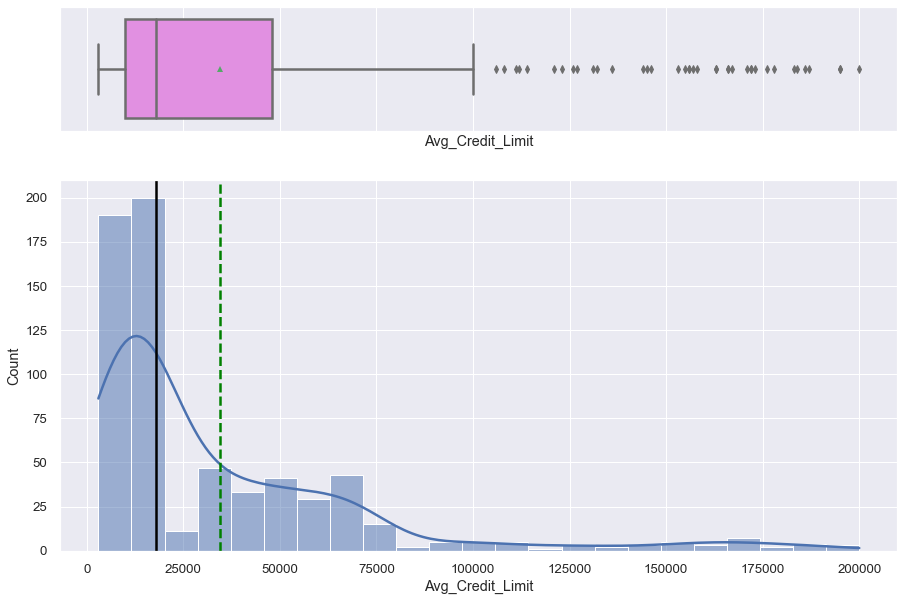

In [14]:
histogram_boxplot(working_df['Avg_Credit_Limit'])

In [15]:
#Interactive plot to hover and check outlier values, median, fences etc
px.box(working_df['Avg_Credit_Limit'], orientation='h', height=200)

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Proportion'>

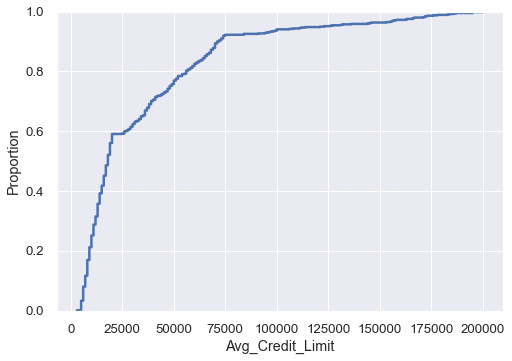

In [16]:
#Plot cdf of feature
sns.ecdfplot(data=working_df,x='Avg_Credit_Limit')

In [17]:
working_df['Avg_Credit_Limit'].describe().T

count       660.000000
mean      34574.242424
std       37625.487804
min        3000.000000
25%       10000.000000
50%       18000.000000
75%       48000.000000
max      200000.000000
Name: Avg_Credit_Limit, dtype: float64

* Avg_Credit_Limit is right skewed
    * mean is ~35000 and median is 18000 
* The boxplot upper fence is at 100,000 and there are a number of outliers beyond that too (up to 200k)
    * However we will scale the entire dataset using zscore so we leave outliers as they are
* About 90% of customers have Avg_Credit_Limit of 75,000 or less, 60% have about 20,000 or less

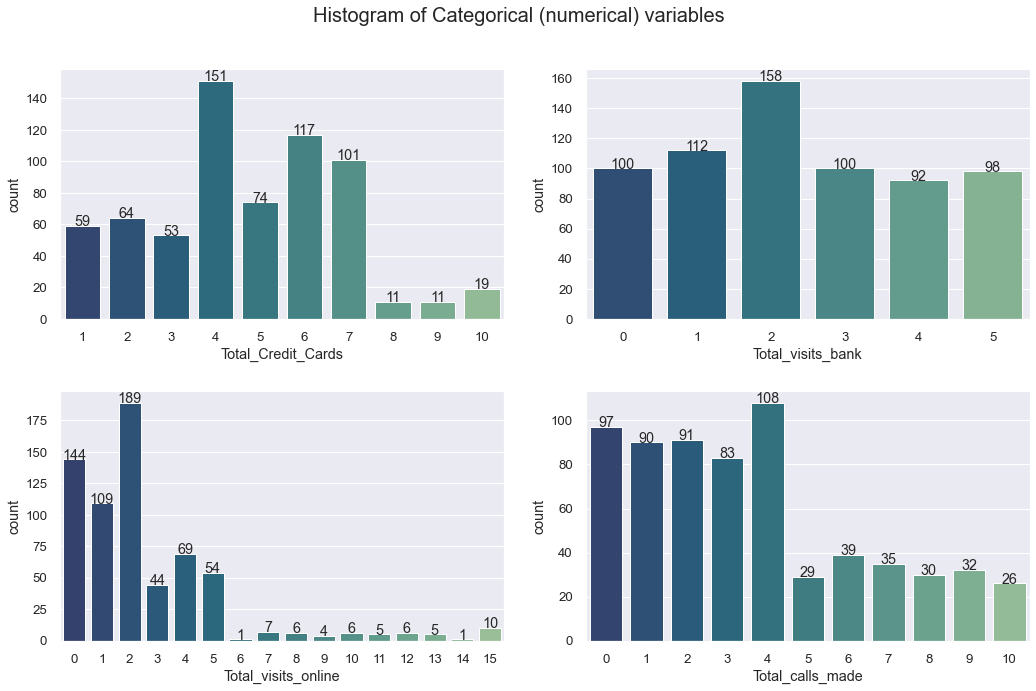

In [18]:
#all_col = working_df.iloc[:,1:].columns
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('Histogram of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.countplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='crest_r')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

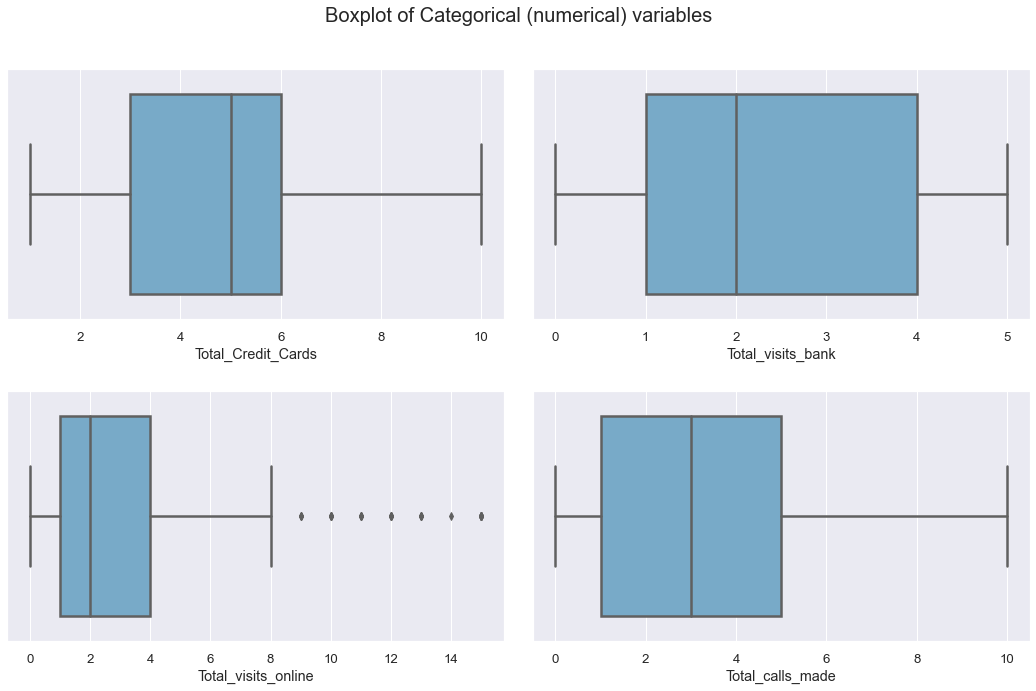

In [19]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('Boxplot of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.boxplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='Blues')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

In [20]:
#Interactive chart to check outliers for total visits online
px.box(working_df['Total_visits_online'], orientation='h', height=200)

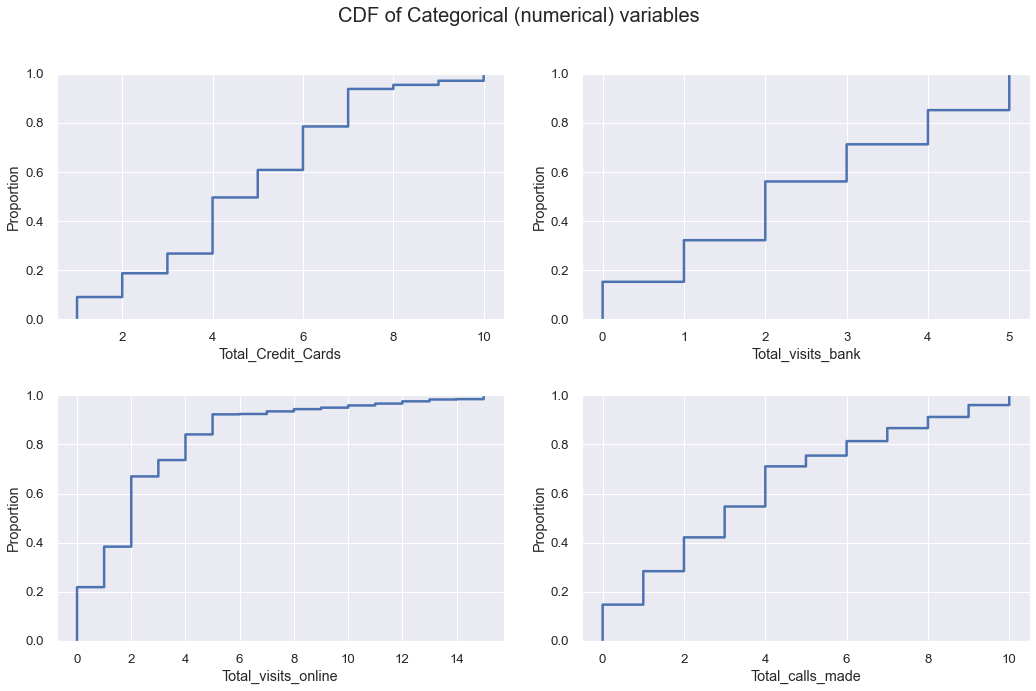

In [21]:
#Plotting CDFs
fig, axes = plt.subplots(2, 2,  figsize=(15, 10))
fig.suptitle('CDF of Categorical (numerical) variables', fontsize=20)
row = 0
for i,column in enumerate(categorical_cols):
    zz=sns.ecdfplot(ax=axes[0 if i<2 else 1,i%2],x=working_df[column], palette='Blues')
    show_values_on_bars(zz)
    #counter = counter+1

fig.tight_layout(pad=2.0)

In [22]:
working_df.loc[:,categorical_cols].describe().T

count      mean       std  min  25%  50%  75%   max
Total_Credit_Cards   660.0  4.706061  2.167835  1.0  3.0  5.0  6.0  10.0
Total_visits_bank    660.0  2.403030  1.631813  0.0  1.0  2.0  4.0   5.0
Total_visits_online  660.0  2.606061  2.935724  0.0  1.0  2.0  4.0  15.0
Total_calls_made     660.0  3.583333  2.865317  0.0  1.0  3.0  5.0  10.0

### Categorical Columns
* Total_Credit_Cards: 
    * About 50% of the data set have 4 credit cards
    * ~80% have 6 or fewer cards and ~95% have 7 or fewer
    * mean/ median for this column is 4.7 and 5 and min/ max is 1 and 10
* Total_visits_bank
    * About 15% have never visited the bank
    * ~85% have made 4 or fewer visits
    * mean/ median for this column is 2.4 and 2 and min/ max is 0 and 5
* Total_visits_online
    * Slightly more than 20% have never made online visits
    * About 92% have made 5 or fewer visits
    * mean/ median for this column is 2.6 and 2 and min/ max is 0 and 15
* Total_calls_made
    * About 75% have made 5 or fewer calls; about 15% have never called
    * About 90% have made 8 or fewer calls
    * IQR upper fence is 8 and points beyond that are outliers (9,10,11,12,13,14,15) - however, we will scale the entire dataset to zscore so we leave it as it is
    * mean/ median for this column is 3.6 and 3 and min/ max is 0 and 10

## 3.   Bivariate Analysis

<AxesSubplot:>

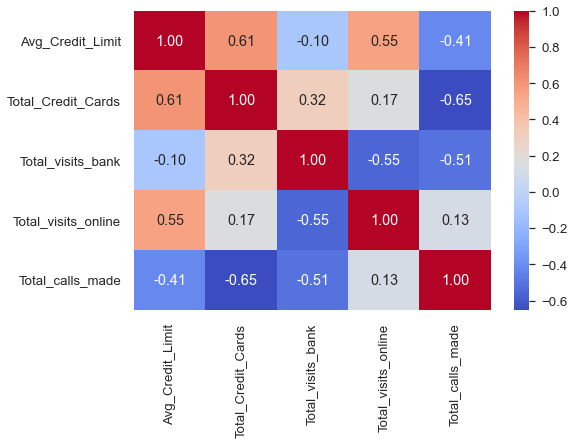

In [23]:
sns.heatmap(working_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')

* There aren't very strong correlations here - however:
    * Avg_Credit_Limit and Total_Credit_Cards have positive correlation of 0.61 - this makes sense since higher spending power/ more credit worthy customers would likely have more cards
    * Avg_Credit_Limit and Total_visits_online have a 0.55 positive correlation
    * Total_calls_made has a negative corr with Total_Credit_Cards of -0.65 
    * Total_calls_made has a negative corr of -0.51 with Total_visits_bank which makes sense as those who call in would likely not need to make as many physical visits
    * Total_visits_online has a negative corr of -0.55 with Total_visits_bank which makes sense as those who call in would likely not need to make as many physical visits


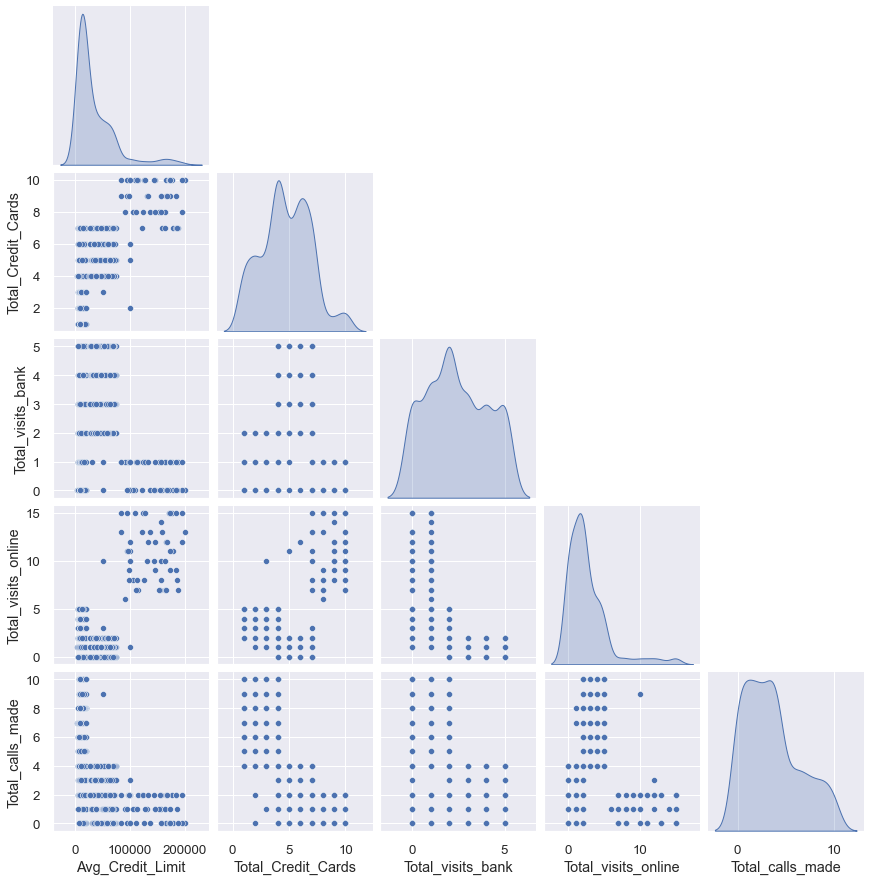

In [24]:
sns.pairplot(working_df, diag_kind='kde', corner=True)

* credit limit, calls made and visits online are right skewed
* total credit cards and total visits are more symmetric
* looking at the peaks in the kde's for total credit cards and visits there might be 4-6 clusters; however looking at others, 3 is also a possibility - will consider 3 - 6 clusters in modelling


## 4. Modelling 

### 4a. Scaling Data - this is important for clustering algorithms as otherwise columns with larger scales will dominate the clustering (since clustering is a distance based algorithm)

In [25]:
#setting random_state 
random_state = 314159

In [26]:
# Scaling the data set before clustering
scaler=StandardScaler()
scaled_data=scaler.fit_transform(working_df)

In [27]:
df_scaled = pd.DataFrame(scaled_data, columns = working_df.columns)
df_scaled

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            1.740187           -1.249225          -0.860451   
1            0.410293           -0.787585          -1.473731   
2            0.410293            1.058973          -0.860451   
3           -0.121665            0.135694          -0.860451   
4            1.740187            0.597334          -1.473731   
..                ...                 ...                ...   
655          1.713589            2.443892          -0.860451   
656          1.314621            2.443892          -0.860451   
657          2.937092            1.520613          -0.860451   
658          3.655235            2.443892          -0.860451   
659          3.522245            1.982253          -1.473731   

     Total_visits_online  Total_calls_made  
0              -0.547490         -1.251537  
1               2.520519          1.891859  
2               0.134290          0.145528  
3              -0.547490          0.145528  
4               3.202298         -0.203739  
..                   ...               ...  
655             2.520519         -1.251537  
656             3.543188         -0.553005  
657             2.179629         -0.902271  
658             4.224968         -1.251537  
659             3.202298         -0.553005  

[660 rows x 5 columns]

In [28]:
df_scaled.describe().T

count          mean       std       min       25%  \
Avg_Credit_Limit     660.0  8.612639e-17  1.000758 -0.839808 -0.653623   
Total_Credit_Cards   660.0  4.306320e-17  1.000758 -1.710864 -0.787585   
Total_visits_bank    660.0 -4.306320e-17  1.000758 -1.473731 -0.860451   
Total_visits_online  660.0  7.536059e-17  1.000758 -0.888380 -0.547490   
Total_calls_made     660.0 -8.612639e-17  1.000758 -1.251537 -0.902271   

                          50%       75%       max  
Avg_Credit_Limit    -0.440840  0.357097  4.399975  
Total_Credit_Cards   0.135694  0.597334  2.443892  
Total_visits_bank   -0.247170  0.979390  1.592670  
Total_visits_online -0.206600  0.475180  4.224968  
Total_calls_made    -0.203739  0.494794  2.241125

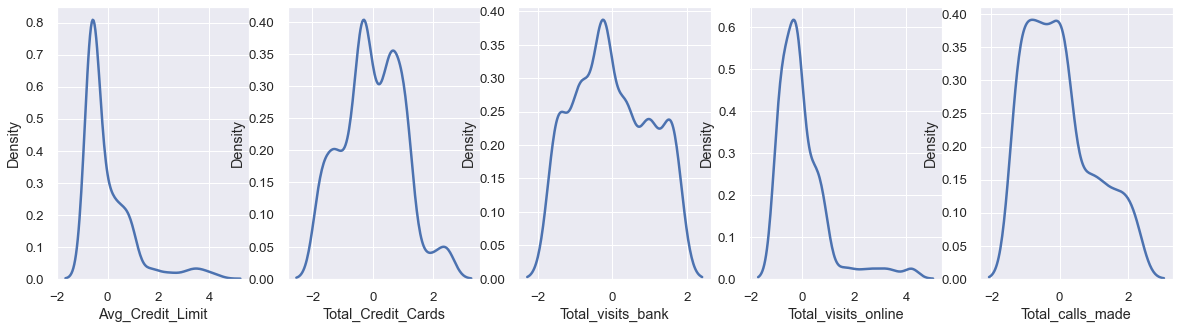

In [29]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i, col in enumerate(df_scaled.columns):
    sns.kdeplot(df_scaled[col], ax=ax[i])

* All data is now scaled using zscores

### 4b. K Means clustering

#### Distortions and elbow plot

In [30]:
clusters=range(1,9) # Although EDA shows likely 3-6 clusters we explore 1-8 (also needed for visualisations below)
meanDistortions=[]
predictions = {}

for k in clusters:
    model=KMeans(n_clusters=k, random_state=random_state) #declare model with k clusters
    model.fit(df_scaled) #fit model to scaled data
    prediction=model.predict(df_scaled) #make predictions of clusters based on scaled data
    predictions[k] = prediction
    #print(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1).shape)
    #Next we compute the distorition ie euclidean distance (variance) within each cluster 
    #cdist finds distances between two matrices - we use euclidean which is passed as parameter
    #the output contains the distance of each row from each centroid 
    #since we need only within cluster variance, we use np.min to select the minimum for each row which
    #of course is its own cluster centroid
    #this is then divided by no of rows to convert to variance
    distortion=sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
                           
    meanDistortions.append(distortion)
    
    print(f'Number of Clusters: {k} \t Average Distortion: {distortion:.3f}')



Number of Clusters: 1 	 Average Distortion: 2.007
Number of Clusters: 2 	 Average Distortion: 1.457
Number of Clusters: 3 	 Average Distortion: 1.147
Number of Clusters: 4 	 Average Distortion: 1.046
Number of Clusters: 5 	 Average Distortion: 0.991
Number of Clusters: 6 	 Average Distortion: 0.943
Number of Clusters: 7 	 Average Distortion: 0.923
Number of Clusters: 8 	 Average Distortion: 0.889


* As the number of clusters increases, the average distortion decreases (as expected)

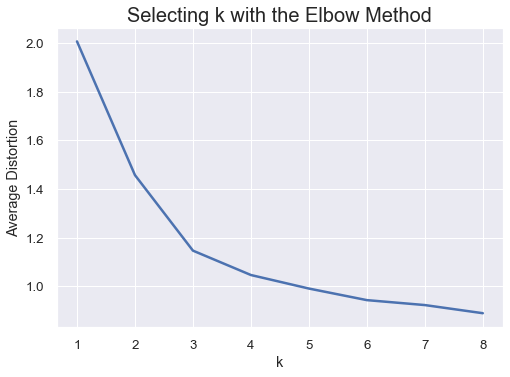

In [31]:
#Plotting elbow plot
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=clusters, y=meanDistortions)
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20);

* We see a sharp elbow at 3 which is likely the appropriate no of clusters for this dataset


#### Examining with silhouette scores as below


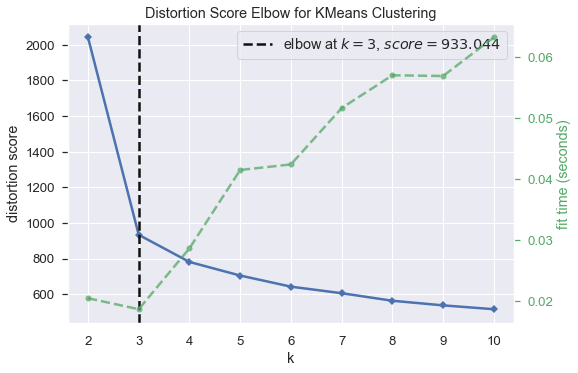

In [32]:
#Using alternative yellowbrick elbow visualiser
visualizer = KElbowVisualizer(KMeans(random_state = random_state))

visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

In [33]:
# Computing Silhouette scores
sil_score = []
cluster_list = list(range(2,9))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    preds = clusterer.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, preds, random_state=random_state)
    sil_score.append(score)
    print(f"For n_clusters = {n_clusters}, silhouette score is {score:.3f})")

For n_clusters = 2, silhouette score is 0.418)
For n_clusters = 3, silhouette score is 0.516)
For n_clusters = 4, silhouette score is 0.356)
For n_clusters = 5, silhouette score is 0.273)
For n_clusters = 6, silhouette score is 0.255)
For n_clusters = 7, silhouette score is 0.235)
For n_clusters = 8, silhouette score is 0.227)


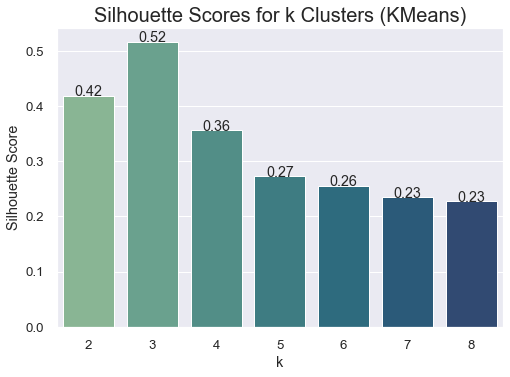

In [34]:
zz=sns.barplot(x=cluster_list,y=sil_score, palette='crest')
show_values_on_bars(zz, decimals=True)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k Clusters (KMeans)', fontsize=20);

* Here again we see for 3 clusters, silhouette score is highest at 0.5157
* Higher silhouette score means each point is well contained in its cluster and is far away from other clusters




#### Silhouette visualiser for k=3 to 6 to see what the cluster silhouette scores look like

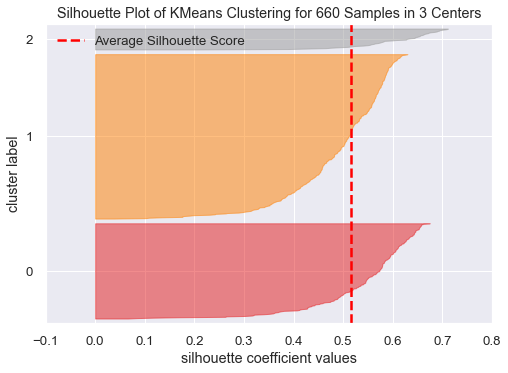

In [35]:

# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

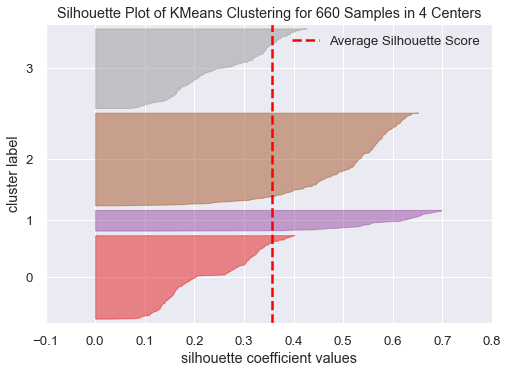

In [36]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

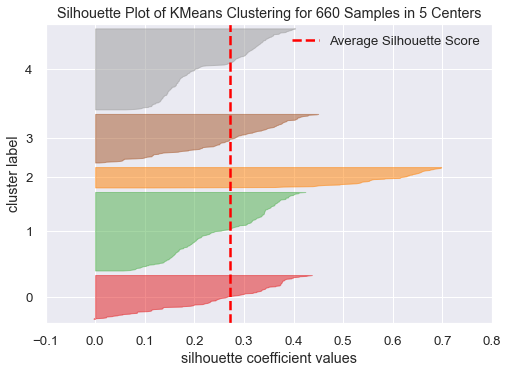

In [37]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

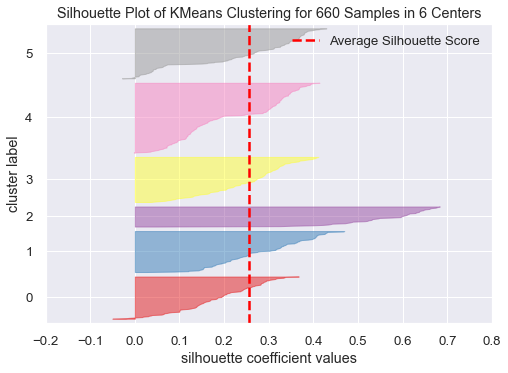

In [38]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state = random_state))
visualizer.fit(df_scaled)    
visualizer.show();

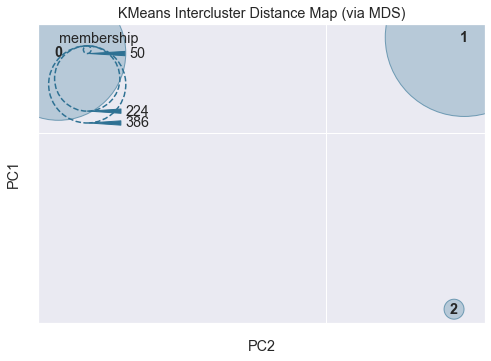

In [39]:
#Using yellowbrick visualiser to check cluster dispersion
'''from the docs: Intercluster distance maps display an embedding of the cluster centers in 2 
dimensions with the distance to other centers preserved. E.g. the closer to centers are in the
visualization, the closer they are in the original feature space. The clusters are sized according to a 
scoring metric. By default, they are sized by membership, e.g. the number of instances that belong to 
each center. This gives a sense of the relative importance of clusters. Note however, that because two clusters
overlap in the 2D space, it does not imply that they overlap in the original feature space.'''

visualizer = InterclusterDistance(KMeans(3, random_state = random_state),legend_loc='upper left')

visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

* Based on the silhouette visualisations, we see that the scores are very widely dispersed for 4,5,6 clusters whereas for 3 clusters, the silhouette scores for all clusters are about the same - this indicates good fit
* However we do see that all clusters are not the same size and the 2nd cluster has very many points while the third cluster has few rows in it

#### Plotting 2d representation of cluster spreads

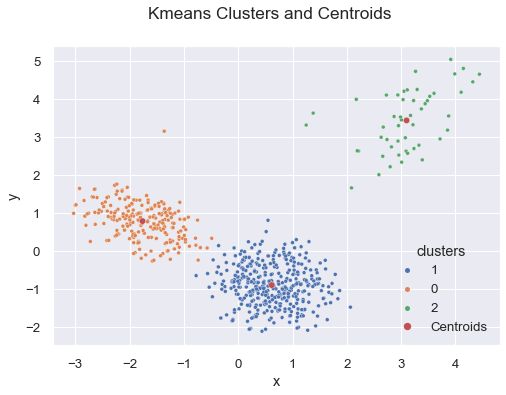

In [40]:
#Plotting 2d projection of clusters - the custom function uses PCA to project 5 feature space onto 2D


model = KMeans(n_clusters=3, random_state=random_state)
showClustersIn2D(model,df_scaled, ax=None, title='Kmeans Clusters and Centroids')

* Based on 2d representation it appears the model has done a good job of clustering the data into 3 clusters

#### Examining Clusters

In [41]:
#Adding a column to working_df with the predictions from our kmeans model where n_clusters = 3
working_df = working_df.assign(kmeans_clusters = predictions[3])
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  kmeans_clusters  
0                      1                 0                1  
1                     10                 9                0  
2                      3                 4                1  
3                      1                 4                1  
4                     12                 3                2  
..                   ...               ...              ...  
655                   10                 0                2  
656                   13                 2                2  
657                    9                 1                2  
658                   15                 0                2  
659                   12                 2                2  

[660 rows x 6 columns]

In [42]:
x=working_df.groupby('kmeans_clusters').mean().iloc[:,:5]
x['no_of_rows']=working_df.groupby('kmeans_clusters')['Avg_Credit_Limit'].count().values
x

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
kmeans_clusters                                                            
0                    12174.107143            2.410714           0.933036   
1                    33782.383420            5.515544           3.489637   
2                   141040.000000            8.740000           0.600000   

                 Total_visits_online  Total_calls_made  no_of_rows  
kmeans_clusters                                                     
0                           3.553571          6.870536         224  
1                           0.981865          2.000000         386  
2                          10.900000          1.080000          50

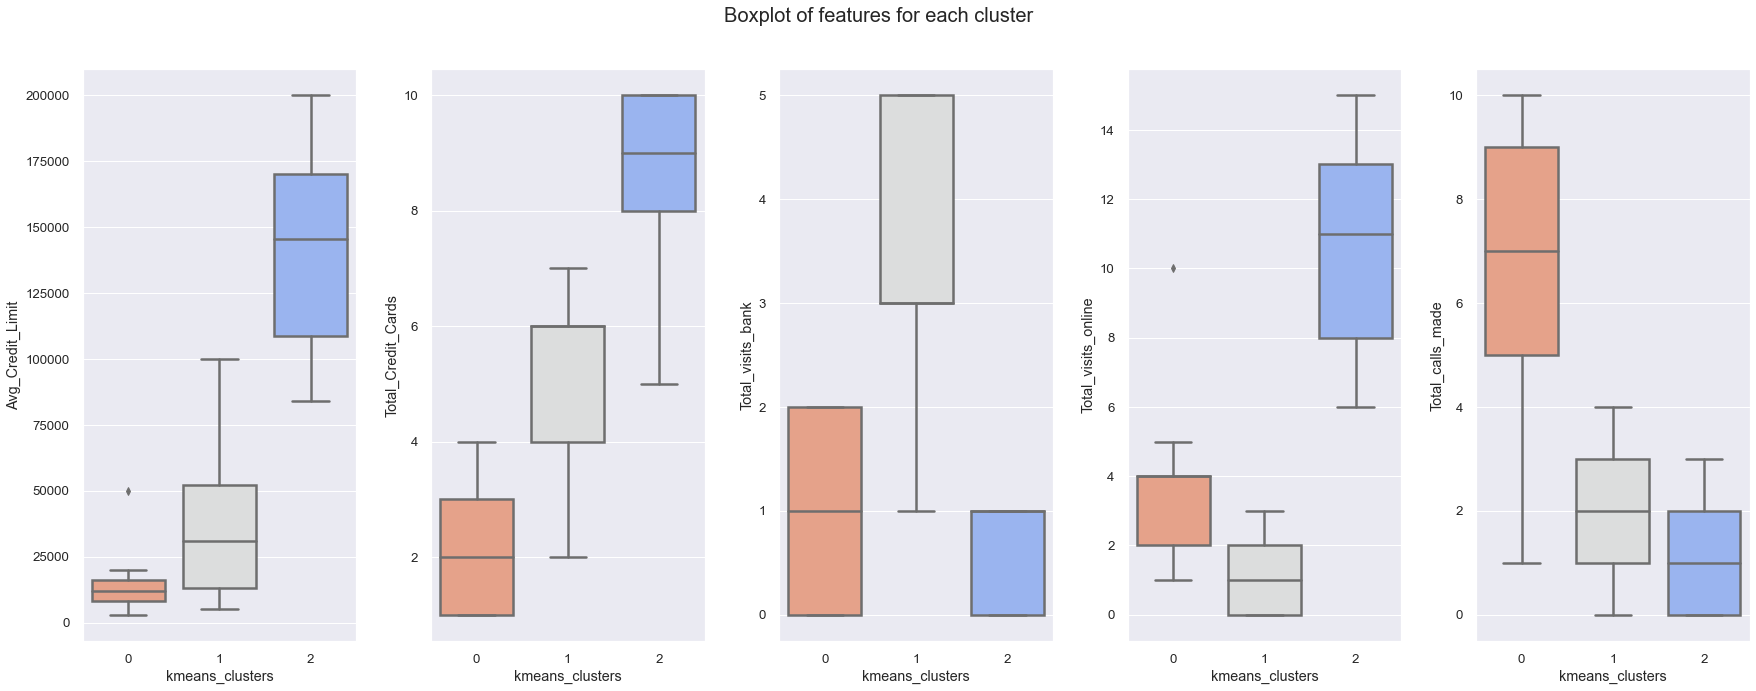

In [43]:
fig, axes = plt.subplots(1, 5,  figsize=(25, 10))
fig.suptitle('Boxplot of features for each cluster', fontsize=20)
counter = 0
for i,column in enumerate(working_df.columns[:-1]):
    sns.boxplot(ax=axes[i],y=working_df[column],x=working_df.kmeans_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

### Cluster Characteristics:
* Cluster 0: (224 rows/ 34%)
    * Avg. credit limit of 12174
    * Have 2.4 credit cards on Avg
    * Made 1 visit to bank, 3.6 online visits and 6.9 calls
    * This cluster has likely lower income people since credit limit and no of cards is lower than other clusters
    * They are most likely to call in to the bank rather than visit online or physically
   
   
* Cluster 1: (386 rows, 58%)
    * Avg. credit limit of 33782
    * Have 5.5 credit cards on Avg
    * Made 3.5 visit to bank, 1 online visits and 2 calls
    * This cluster is likely customers who have spending power between the other two clusters as credit limit and no of cards is more than in cluster 0 but less than cluster 2
    * These customers are most likely to make physical visits to the bank
  
  
* Cluster 2: (50 rows, 8%)
    * Avg. credit limit of 141040
    * Have 8.7 credit cards on Avg
    * Made .6 visit to bank, 10.9 online visits and 1.1 calls
    * These are likely high networth individuals as the mean credit limit is significantly higher than the other two clusters and they also own more credit cards - very small % of rows which is typical of percentage of HNI customers in a bank
    * These customers are more likely to make online visits
    
    
* The clusters seem quite distinct and it appears the model works well in segregating the dataset into unique and distinct groups with their own behaviour characteristics
    * Based on the above, the bank would be well served to tune the delivery channels (physical, online, call) to the needs of each cluster - customers can be grouped by credit limit and cards

### 4c. Hierarchical Clustering

#### First we check for best cophenetic coeff amongst the following methods and metrics

In [44]:
# cophenet index is a measure of the correlation between the distance of points in 
#feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

#since there are outliers, it is good practice to check distance metrics other than euclidean 
#which doesnt handle outliers as well as the others. Mahalanobis is esp used for outlier cases
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock'] 

#The following linkage methods work for all metrics listed above
linkage_methods = ['single', 'complete', 'average', 'weighted']

corrs=[] 
corr_d = {}

for dm in distance_metrics:
    
    corrs=[]
    for lm in linkage_methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(df_scaled))
        corrs.append(c)

    corr_d[dm] = corrs


corr_df = pd.DataFrame.from_dict(corr_d, orient='index', columns=linkage_methods)
max_method=corr_df.max().idxmax()
max_metric=corr_df[max_method].idxmax()
max_corr = corr_df.loc[max_metric,max_method]



print("Cophenetic coeff for methods and metrics are:")
#corr_df.style.apply(highlight_max, color='darkorange', axis=None)

display(corr_df.style.apply(highlight_max, color='darkorange', axis=None))
print(f'\nMax value of coeff is {max_corr:.5f} which is for metric: {max_metric} and method: {max_method}')

Cophenetic coeff for methods and metrics are:



Max value of coeff is 0.89771 which is for metric: euclidean and method: average


* We see that the best fit tree (determined by the highest cophenetic coeff is for the euclidean metric with average method

#### Now we check cophenetic for median, ward and centroid which only work with metric = euclidean

In [45]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted', 'centroid']

corrs=[]
corr_d2 = {}

for lm in linkage_methods:
    Z = linkage(df_scaled, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(df_scaled))
    corrs.append(c)

corr_d2['euclidean'] = corrs


corr_df2 = pd.DataFrame.from_dict(corr_d2, orient='index',columns=linkage_methods)
max_method2=corr_df2.max().idxmax()
max_metric2=corr_df2[max_method].idxmax()
max_corr2 = corr_df2.loc[max_metric,max_method]

print("Cophenetic coeff for methods and metrics are:")
display(corr_df2.style.apply(highlight_max, color='darkorange', axis=None))
print(f'\nMax value of coeff is {max_corr2:.6f} which is for metric: {max_metric2} and method: {max_method2}')
    

Cophenetic coeff for methods and metrics are:



Max value of coeff is 0.897708 which is for metric: euclidean and method: average


* We see that across all the methods and metrics evaluated, the best cophenetic correlation is for euclidean with average linkage method



#### Evaluating various dendogram structures for metrics = chebyshev, mahalanobis and cityblock with linkage methods = average, weighted

CPU times: user 5.01 s, sys: 313 ms, total: 5.32 s
Wall time: 3.92 s


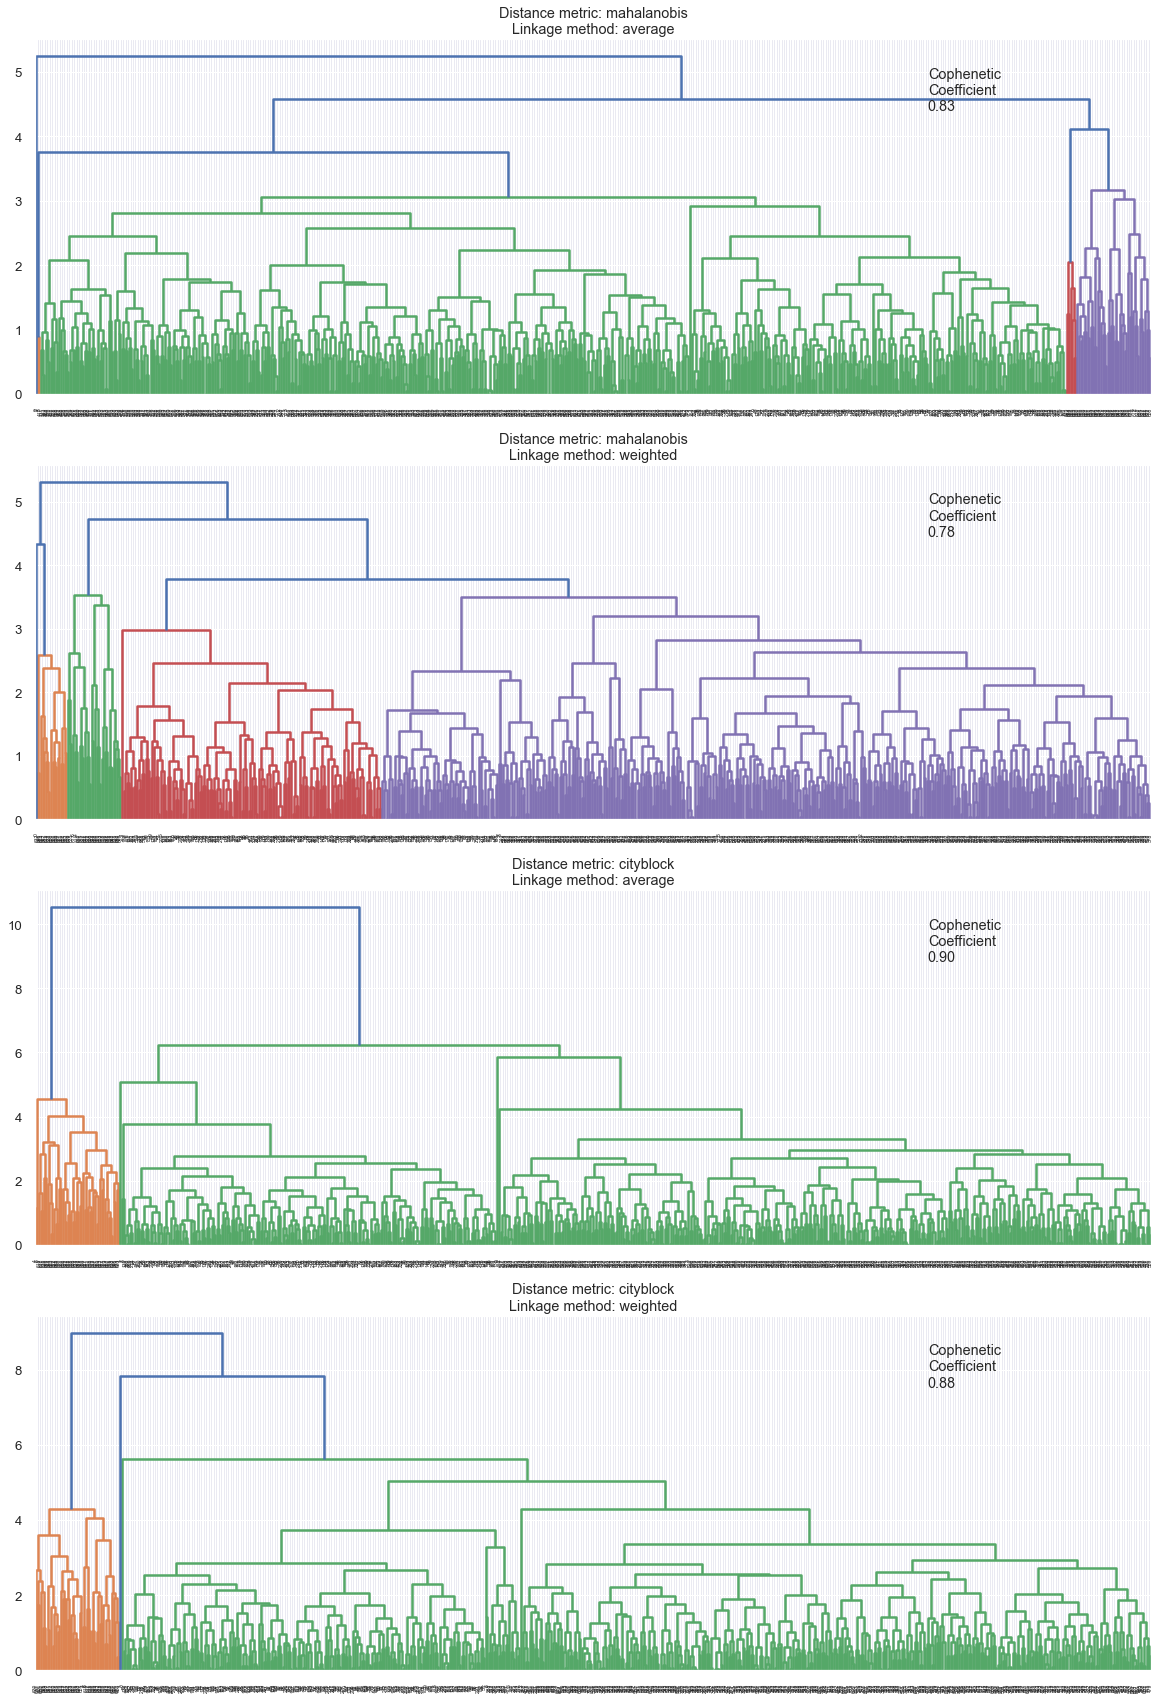

In [46]:
%%time

methods=['average','weighted']
metrics=['mahalanobis', 'cityblock']

fig, axs = plt.subplots(len(metrics)*len(methods), 1, figsize=(20, 30))
i=0
for dm in metrics:
    for lm in methods:
        Z = linkage(df_scaled, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metric: {}\nLinkage method: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        #axs[i].set_title('Distance metric: {}\nLinkage method: {}'.format(dm,lm))                        
        i +=1
       


#### Evaluating various dendogram structures for euclidean with different linkage methods

CPU times: user 6.52 s, sys: 256 ms, total: 6.77 s
Wall time: 5.38 s


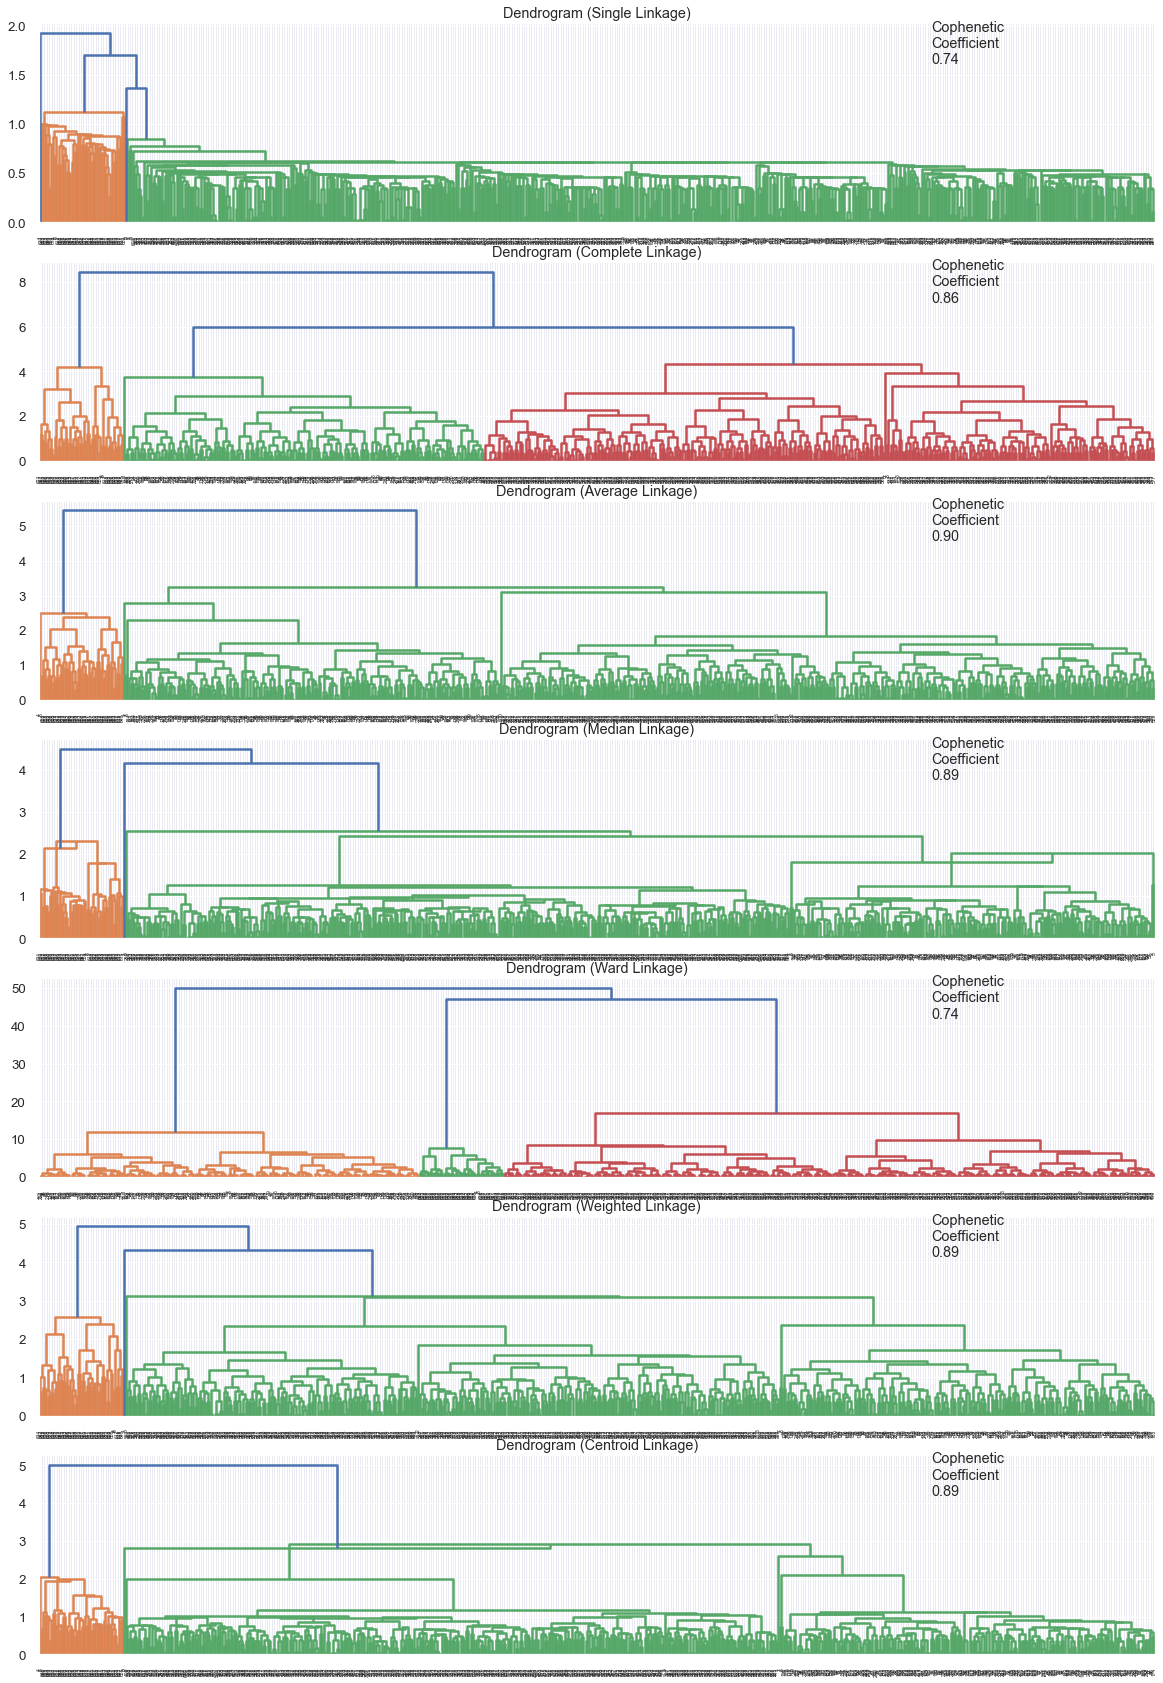

In [47]:
%%time


# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(20, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(linkage_methods):
    
    Z = linkage(df_scaled, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(df_scaled))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

* The ward method with euclidean shows 3 clear clusters; however avg has a significantly higher coph coeff
    * also while colors don't show up at about y=3.2 on the dendogram, there are 3 clusters for average as well (see appendix which also corroborates 3 clusters at maxd of 3.2)
* Appendix at end of notebook has alt method of clustering and for comparison of clusters formed by different linkages
* As it turns out there isnt much difference between using ward or average but I use avg as it has a higher coph corr (analysis in appendix)
    * Complete also has 3 clear clusters but as we see in the appendix later, it doesnt do as good a job of clustering as do ward and avg



In [48]:
chosen_method='average'
chosen_metric='euclidean'

#### Checking that our custom class works same as the parent sklearn.cluster.AgglomerativeClustering

In [49]:
mod2 = AgglomerativeClusteringWithPredict(n_clusters=3,affinity=chosen_metric, linkage=chosen_method)
x=mod2.fit_predict(df_scaled)
y=AgglomerativeClustering(n_clusters=3,affinity=chosen_metric, linkage=chosen_method).fit_predict(df_scaled)
print(f'Making sure that predictions returned by my custom class are the same as those returned by the parent \
class: {sum(x==y)==working_df.shape[0]}')
#working_df['HC_Clusters'] = HCmodel.labels_

Making sure that predictions returned by my custom class are the same as those returned by the parent class: True


#### Silhouette scores for different cluster numbers

In [50]:
#Examining silhouette scores for various values of n_clusters
silscores = {}
for i in range(2,10):
    HCmodel = AgglomerativeClusteringWithPredict(n_clusters=i, affinity=chosen_metric, linkage=chosen_method)
    HCmodel.fit(df_scaled)
    silscores[i] = silhouette_score(df_scaled,HCmodel.labels_)

print("silhouette scores for agglomerative clustering with various values of n_clusters are:")
silscores

silhouette scores for agglomerative clustering with various values of n_clusters are:


{2: 0.5703183487340514,
 3: 0.515922432650965,
 4: 0.47495143595793504,
 5: 0.44039753024783956,
 6: 0.4153547954831452,
 7: 0.4183775674672025,
 8: 0.34306710358280806,
 9: 0.3415486932890892}

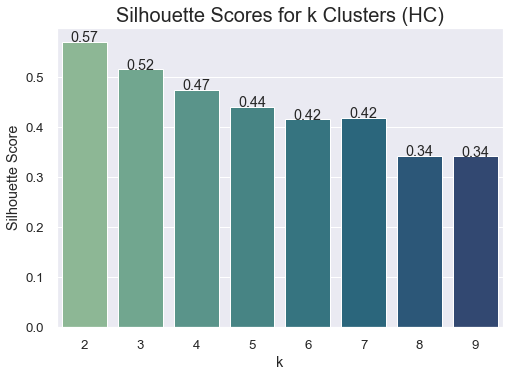

In [51]:
sildf=pd.DataFrame.from_dict(silscores, orient='index', columns=['Silhouette Scores'])#.plot(kind='bar')
zz=sns.barplot(data=sildf, x=sildf.index, y=sildf['Silhouette Scores'], palette='crest')
show_values_on_bars(zz, decimals=True)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for k Clusters (HC)', fontsize=20);
del(sildf)

* Silhouette score is better when close to +1; therefore 0.51 is a decent outcome for k=3
    * Very similar to the Silhouette score generated by kmeans
* k=2 has a better silhouette score but as we see below elbow plot clearly indicates k=3

#### Distortions and elbow plot

In [52]:
clusters=range(2,9) # Although EDA shows likely 3-6 clusters we explore 1-8 (also needed for visualisations below)
meanDistortions=[]
predictions = {}

for k in clusters:
    #declare model with k clusters
    model=AgglomerativeClusteringWithPredict(n_clusters=k, affinity=chosen_metric, linkage=chosen_method) 
    model.fit(df_scaled) #fit model to scaled data
    prediction=model.fit_predict(df_scaled) #make predictions of clusters based on scaled data
    predictions[k] = prediction
    #print(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1).shape)
    #Next we compute the distorition ie euclidean distance (variance) within each cluster 
    #cdist finds distances between two matrices - we use euclidean which is passed as parameter
    #the output contains the distance of each row from each centroid 
    #since we need only within cluster variance, we use np.min to select the minimum for each row which
    #of course is its own cluster centroid
    #this is then divided by no of rows to convert to variance
    #pprint(model.cluster_centers_)
    distortion=sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
                           
    meanDistortions.append(distortion)
    
    print(f'Number of Clusters: {k} \t Average Distortion: {distortion:.3f}')



Number of Clusters: 2 	 Average Distortion: 1.718
Number of Clusters: 3 	 Average Distortion: 1.147
Number of Clusters: 4 	 Average Distortion: 1.142
Number of Clusters: 5 	 Average Distortion: 1.138
Number of Clusters: 6 	 Average Distortion: 1.132
Number of Clusters: 7 	 Average Distortion: 1.113
Number of Clusters: 8 	 Average Distortion: 1.106


* As the number of clusters increases, the average distortion decreases (as expected)

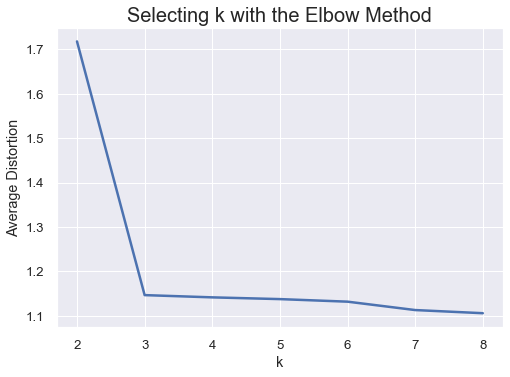

In [53]:
#Plotting elbow plot
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=clusters, y=meanDistortions)
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20);

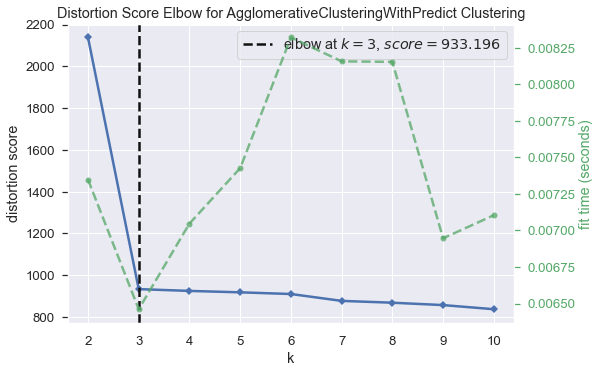

In [54]:
#Alternative elbowplot visualisation using yellowbrick
visualizer = KElbowVisualizer(AgglomerativeClusteringWithPredict(n_clusters=None,affinity=chosen_metric, \
                                                                 linkage=chosen_method))
visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.show();

* Both the custom elbow visualiser I wrote and the Yellowbrick elbow visualizer found a clear elbow at k = 3


#### Cluster representation in 2d

In [55]:

#Adding cluster labels as a column in the df

HCmodel = AgglomerativeClusteringWithPredict(n_clusters=3, affinity=chosen_metric, linkage=chosen_method)
HCmodel.fit_predict(df_scaled)
working_df['hc_clusters'] = HCmodel.labels_

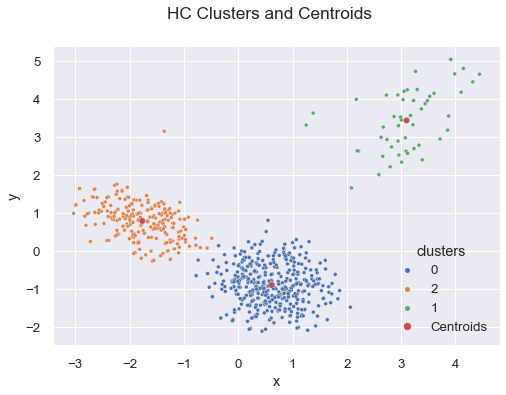

In [56]:
showClustersIn2D(HCmodel, df_scaled, title='HC Clusters and Centroids')

* Based on 2d representation it appears the model has done a good job of clustering the data into 3 clusters

#### Examining clusters

In [57]:
x=working_df.groupby('hc_clusters').mean().iloc[:,:5]
x['no_of_rows'] = working_df.groupby('hc_clusters')['Avg_Credit_Limit'].count().values
x

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters                                                            
0                33713.178295            5.511628           3.485788   
1               141040.000000            8.740000           0.600000   
2                12197.309417            2.403587           0.928251   

             Total_visits_online  Total_calls_made  no_of_rows  
hc_clusters                                                     
0                       0.984496          2.005168         387  
1                      10.900000          1.080000          50  
2                       3.560538          6.883408         223

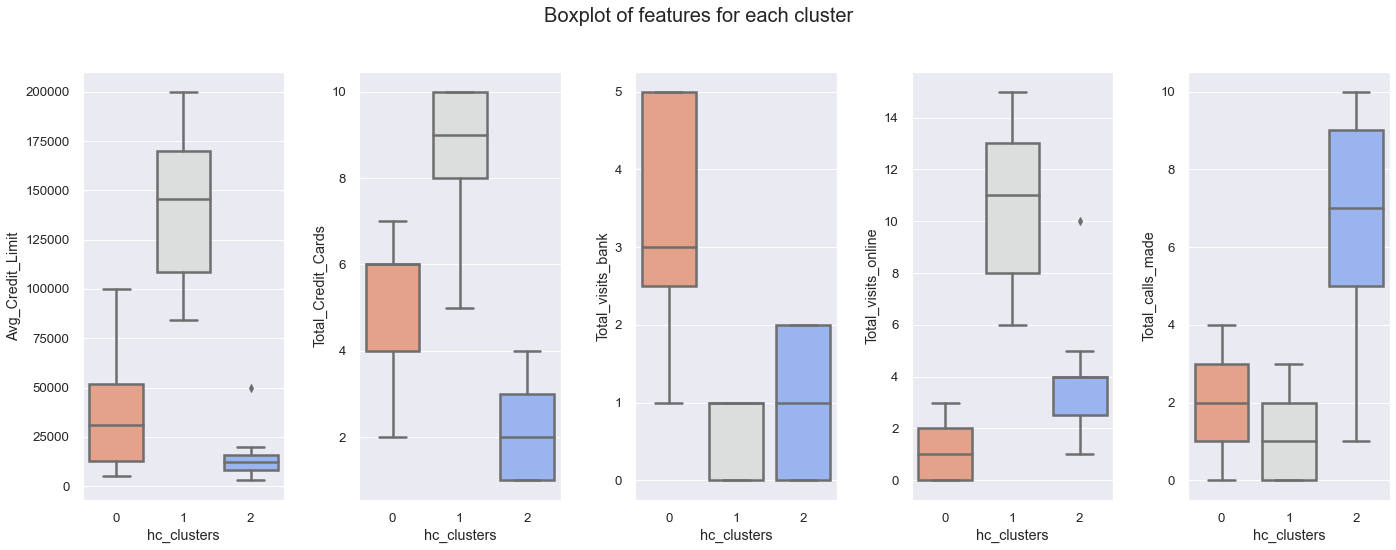

In [58]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 8))
fig.suptitle('Boxplot of features for each cluster', fontsize=20)

for i,column in enumerate(working_df.columns[:5]):
    sns.boxplot(ax=axes[i],y=working_df[column],x=working_df.hc_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

* These clusters are very similar to the ones from k means (except are labelled differently)
* Will compare more closely with k means after relabeling so as to have same cluster names


#### Comparing Hierarchical and Kmeans Clusters

In [59]:
#Lets relabel Heirarchical clusters to better compare to kmeans

def chglbl(x):
    '''if x==0:
        return x
    elif x==1:
        return 2
    else:
        return 1'''
    return (x+1)%3
working_df['hc_clusters_relabel'] = working_df['hc_clusters'].map(chglbl)

In [60]:
(working_df.hc_clusters_relabel==working_df.kmeans_clusters).value_counts()

True     659
False      1
dtype: int64

* only one row is differently grouped by kmeans and HC - that row is as below:

In [61]:
working_df[working_df.hc_clusters_relabel!=working_df.kmeans_clusters]

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
313              7000                   4                  2   

     Total_visits_online  Total_calls_made  kmeans_clusters  hc_clusters  \
313                    2                 4                0            0   

     hc_clusters_relabel  
313                    1

In [62]:
x=working_df.groupby('kmeans_clusters').mean().iloc[:,:5]
x['no_of_rows'] = working_df.groupby('kmeans_clusters')['Avg_Credit_Limit'].count().values

y=working_df.groupby('hc_clusters_relabel').mean().iloc[:,:5]
y['no_of_rows'] = working_df.groupby('hc_clusters_relabel')['Avg_Credit_Limit'].count().values

display(x)
display(y)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
kmeans_clusters                                                            
0                    12174.107143            2.410714           0.933036   
1                    33782.383420            5.515544           3.489637   
2                   141040.000000            8.740000           0.600000   

                 Total_visits_online  Total_calls_made  no_of_rows  
kmeans_clusters                                                     
0                           3.553571          6.870536         224  
1                           0.981865          2.000000         386  
2                          10.900000          1.080000          50

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters_relabel                                                            
0                        12197.309417            2.403587           0.928251   
1                        33713.178295            5.511628           3.485788   
2                       141040.000000            8.740000           0.600000   

                     Total_visits_online  Total_calls_made  no_of_rows  
hc_clusters_relabel                                                     
0                               3.560538          6.883408         223  
1                               0.984496          2.005168         387  
2                              10.900000          1.080000          50

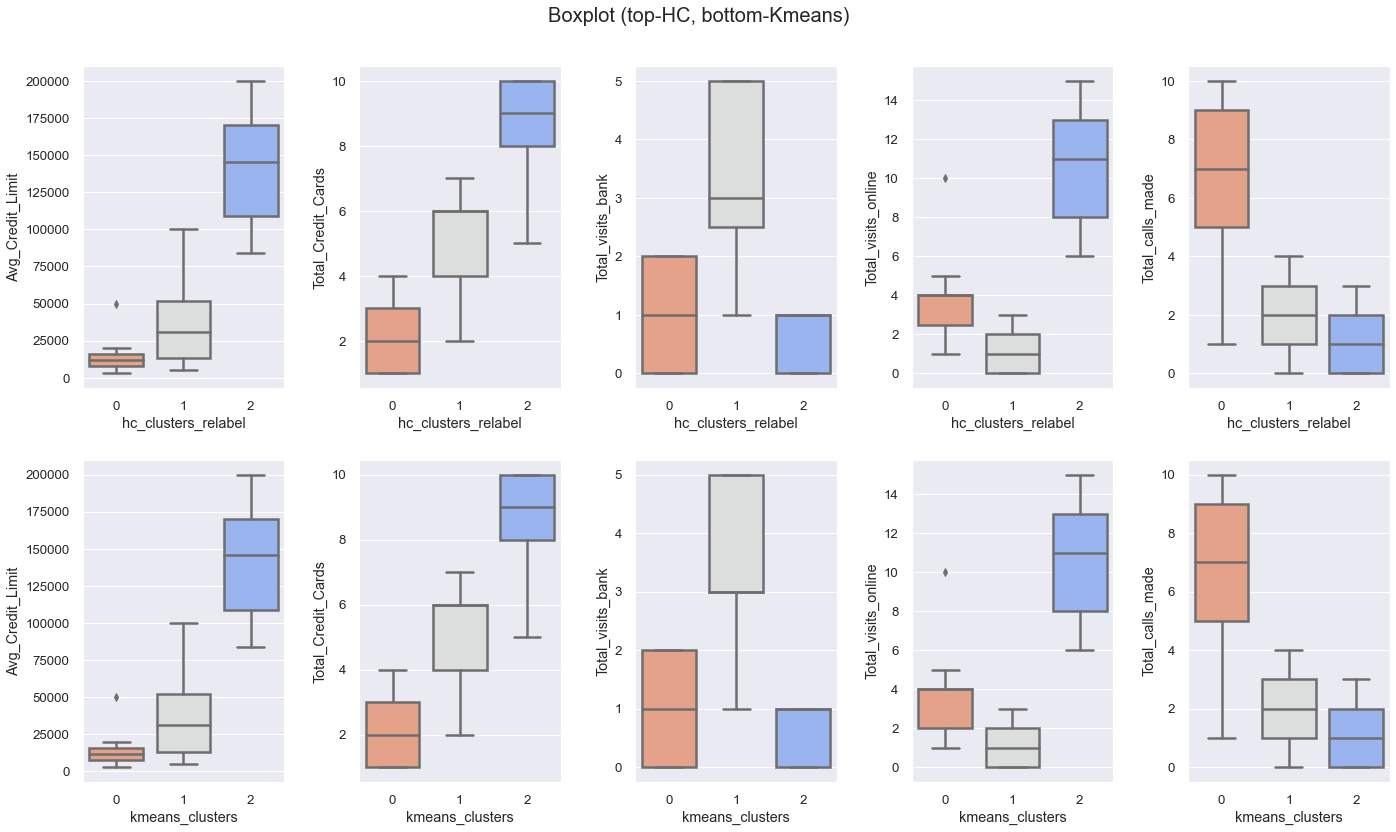

In [63]:
fig, axes = plt.subplots(2, 5,  figsize=(20, 12))
fig.suptitle('Boxplot (top-HC, bottom-Kmeans)', fontsize=20)
counter = 0
for i,column in enumerate(working_df.columns[:5]):
    sns.boxplot(ax=axes[0,i],y=working_df[column],x=working_df.hc_clusters_relabel, palette='coolwarm_r')
    sns.boxplot(ax=axes[1,i],y=working_df[column],x=working_df.kmeans_clusters, palette='coolwarm_r')
    

fig.tight_layout(pad=2.0)

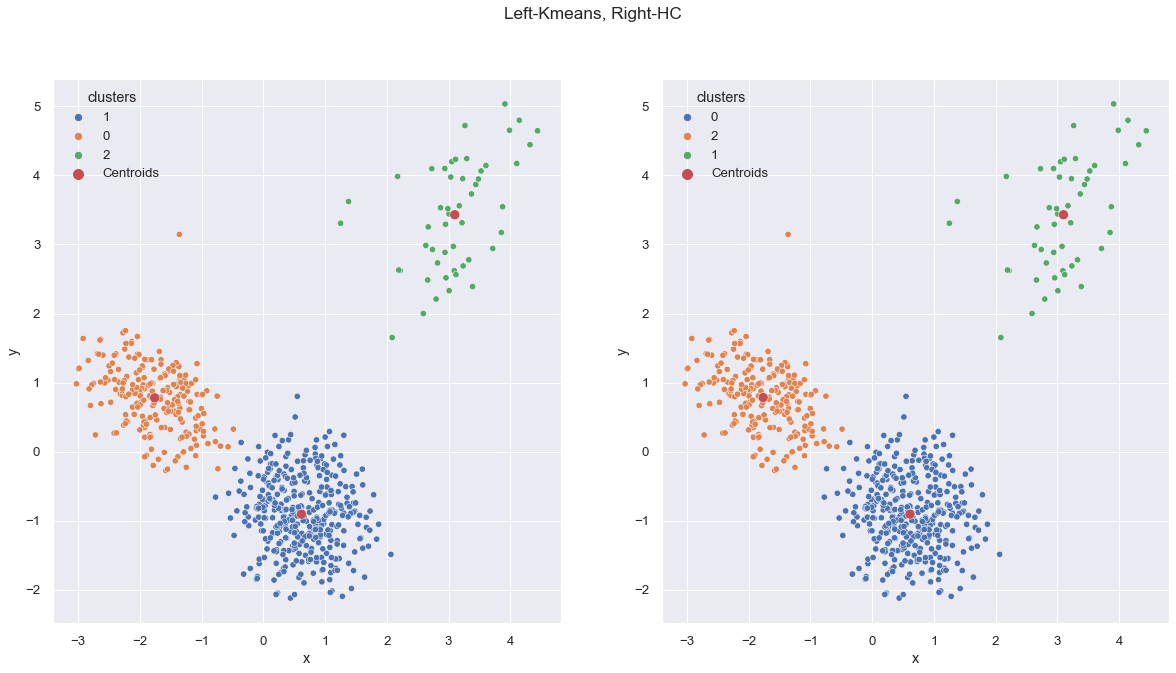

In [64]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
showClustersIn2D(KMeans(n_clusters=3,random_state=random_state), df_scaled, ax=axes[0], \
                 centroid_size=100, point_size=40)
showClustersIn2D(AgglomerativeClusteringWithPredict(n_clusters=3, affinity=chosen_metric, linkage=chosen_method), \
                 df_scaled, title="Left-Kmeans, Right-HC", ax=axes[1], centroid_size=100, point_size=40)
#note that have not relabelled HC clusters as with the boxplot above (not needed as the color codes are clear)

* Clusters generated by both methods are nearly identical
    * only one row is differently clustered
* 2d representation of clusters and centroids: We saw earlier only one row is different between the two methods - that is represented as a point in the box between x=-1,0 and y=-1,0 - top left dot near top of that box is orange for Kmeans and blue for HC
* Analysis and recommendations based on kmeans and heirarchical is therefore the same


### Cluster Characteristics (HC, euclidean, average):
* Cluster 0: (223 rows, 34%)
    * Avg. credit limit of 12k
    * Have 2.4 credit cards on Avg
    * Made 1 visit to bank, 3.5 online visits and 6.9 calls
    * This cluster has likely lower income people since credit limit and no of cards is lower than other clusters
    * They are most likely to call in to the bank rather than visit online or physically
  

* Cluster 1: (387 rows, 58%)
    * Avg. credit limit of 34k
    * Have 5.5 credit cards on Avg
    * Made 3.5 visit to bank, 1 online visits and 2 calls
    * This cluster is likely customers who have spending power between the other two clusters as credit limit and no of cards is more than in cluster 0 but less than cluster 2
    * These customers are most likely to make physical visits to the bank
    
    
* Cluster 2: (50 rows, 8%)
    * Avg. credit limit of 141040
    * Have 8.7 credit cards on Avg
    * Made 0.6 visit to bank, 10.9 online visits and 1.1 calls
    * These are likely high networth individuals as the mean credit limit is significantly higher than the other two clusters and they also own more credit cards - very small % of rows which is typical of percentage of HNI customers in a bank
    * These customers are more likely to make online visits


* The clusters seem quite distinct and it appears the model works well in segregating the dataset into unique and distinct groups with their own behaviour characteristics


* Based on the above, the bank would be well served to tune the delivery channels (physical, online, call) to the needs of each cluster - customers can be grouped by credit limit and cards



### Cluster Specific Recommendations

* Cluster 0 make connections with the bank in the ratio 7:3.5:1 (phone: online: physical) ie the probability that they will choose to connect by phone is 60% and 31% by online.
    * Since such customers are most comfortable on the phone, the bank should check what key tasks they perform on phone banking and train operators to better help them to improve service standards
    * While a substantial portion of these customers use online, the bank should try to motivate more customers to move online as that is the most scalable delivery channel
    * Telemarketing and online/ email promotions are also likely to be succesful with this group
  

* Cluster 1 make connections in the ratio 2:1:3.5 (phone: online: physical) ie the probability that they will chose to connect physically is the highest (54%), followed by phone calls (31%)
    * The bank should examine why these customers are visiting the bank - this is widely believed to be the most inefficient channel of customer service and the most likely to be overwhelmed by volume (can't scale easily) and cause delays and frustration
    * This is particularly troubling since this is the largest cluster in the dataset (58% of rows) - ***this is likely a key cause of customer dissatisfaction since physical is known to be a problematic delivery model for banking***
    * Once the bank knows why they visit the bank, it should inform these customers by way of a targetted campaign (email and/ or sms) that the same tasks can be conducted quicker online or on phone banking
    * The most efficient way to market to these customers is by training branch staff to upsell/ cross-sell to these customers when they walk in
        * Additionally staff should opportunistically offer an on site tutorial on how to use the website when these customers walk in (time permitting)
  

* Cluster 2 make connections in the ratio 1:11:.6 (phone: online: physical) ie the probabiliy that they will chose to connect online is 87% 
    * Online theoretically should be the quickest way for customers to help themselves so theoretically these customers should be satisfied with the online experience. If not, there may be a need to reorganise the online site to make tasks easier, etc. In any case this segment is probably the best to get feedback on how to improve the online site as they are frequent users 
    * The most efficient way to market other products to these customers is to show offers on the banking homepage or by way of email (since these consumers are tech savvy in any case)

## Key Questions

1.  How many different segments of customers are there?
    - There are 3 segments
2.  How are these segments different from each other?
    - The segments differ considerably both in their characteristics (avg credit limit and number of cards held as well as in their engagement behaviour - in person visits, online, phone calls)
    - Please see section above for description of key differences
3.  What  are  your recommendations  to  the  bank  on  how  to  better  market  to  and service these customers?
    - Please see section above for suggestions

## Appendix

### Appendix 1: Alternate Method of Hierarchical Clustering

In [65]:

Z = linkage(df_scaled, chosen_method, metric=chosen_metric) 
Z.shape

(659, 4)

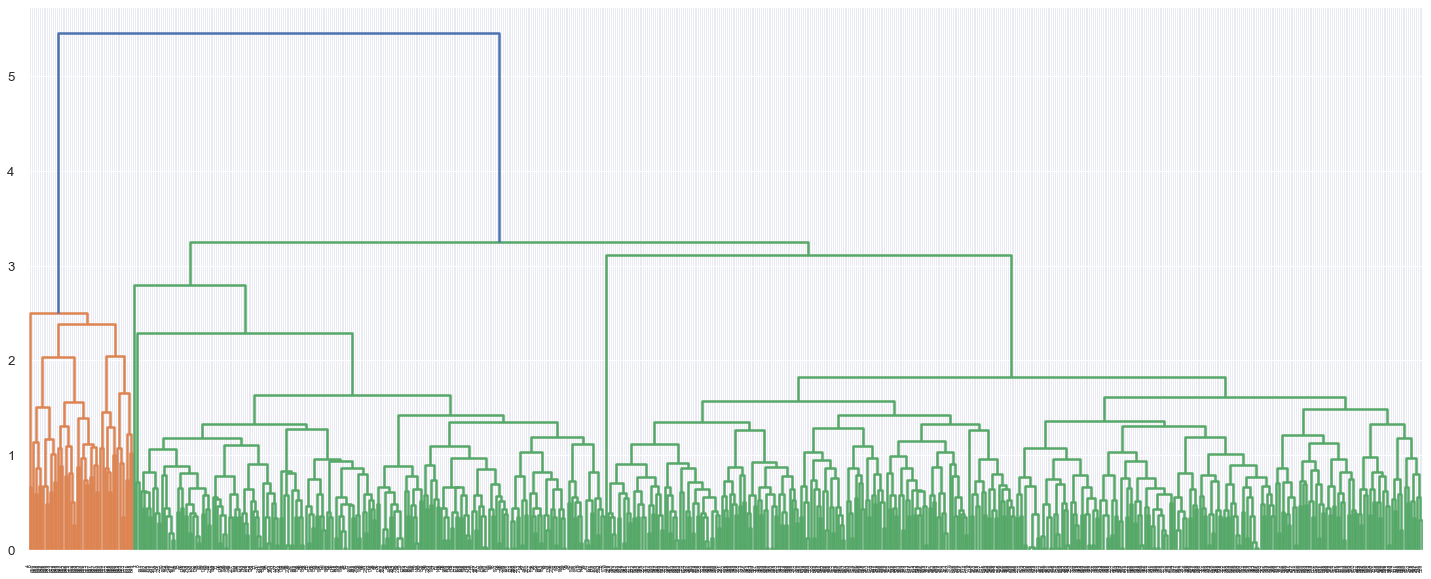

In [66]:
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

In [67]:
max_d = 3.2 # based on full denogram around this distance there are 3 clear clusters

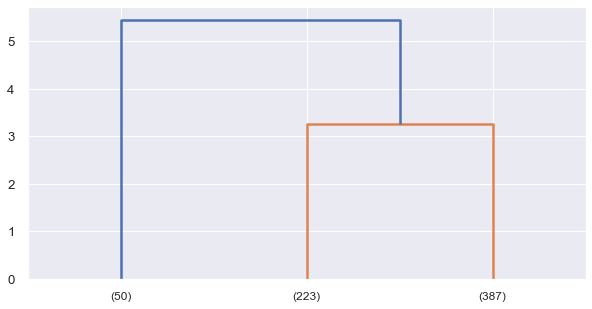

In [68]:
# Using truncate_mode='lastp' attribute in dendrogram function to arrive at dendrogram
plt.figure(figsize=(10,5))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

* We see the clusters have 223, 50 and 387 rows similar to what we saw using Kmeans and AgglomerativeClustering

In [69]:
#Pulling out cluster labels
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([3, 2, 3, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [70]:
#Assiging cluster labels to a new column in the df
working_df['alt_hc_labels'] = clusters

In [71]:
working_df

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              100000                   2                  1   
1               50000                   3                  0   
2               50000                   7                  1   
3               30000                   5                  1   
4              100000                   6                  0   
..                ...                 ...                ...   
655             99000                  10                  1   
656             84000                  10                  1   
657            145000                   8                  1   
658            172000                  10                  1   
659            167000                   9                  0   

     Total_visits_online  Total_calls_made  kmeans_clusters  hc_clusters  \
0                      1                 0                1            0   
1                     10                 9                0            2   
2                      3                 4                1            0   
3                      1                 4                1            0   
4                     12                 3                2            1   
..                   ...               ...              ...          ...   
655                   10                 0                2            1   
656                   13                 2                2            1   
657                    9                 1                2            1   
658                   15                 0                2            1   
659                   12                 2                2            1   

     hc_clusters_relabel  alt_hc_labels  
0                      1              3  
1                      0              2  
2                      1              3  
3                      1              3  
4                      2              1  
..                   ...            ...  
655                    2              1  
656                    2              1  
657                    2              1  
658                    2              1  
659                    2              1  

[660 rows x 9 columns]

#### Comparing clusters with Agglomerative and this method

In [72]:
display(working_df.groupby('alt_hc_labels').count())
display(working_df.groupby('hc_clusters').count())

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
alt_hc_labels                                                            
1                            50                  50                 50   
2                           223                 223                223   
3                           387                 387                387   

               Total_visits_online  Total_calls_made  kmeans_clusters  \
alt_hc_labels                                                           
1                               50                50               50   
2                              223               223              223   
3                              387               387              387   

               hc_clusters  hc_clusters_relabel  
alt_hc_labels                                    
1                       50                   50  
2                      223                  223  
3                      387                  387

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters                                                            
0                         387                 387                387   
1                          50                  50                 50   
2                         223                 223                223   

             Total_visits_online  Total_calls_made  kmeans_clusters  \
hc_clusters                                                           
0                            387               387              387   
1                             50                50               50   
2                            223               223              223   

             hc_clusters_relabel  alt_hc_labels  
hc_clusters                                      
0                            387            387  
1                             50             50  
2                            223            223

In [73]:
display(working_df.groupby('alt_hc_labels').mean())
display(working_df.groupby('hc_clusters').mean())

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
alt_hc_labels                                                            
1                 141040.000000            8.740000           0.600000   
2                  12197.309417            2.403587           0.928251   
3                  33713.178295            5.511628           3.485788   

               Total_visits_online  Total_calls_made  kmeans_clusters  \
alt_hc_labels                                                           
1                        10.900000          1.080000         2.000000   
2                         3.560538          6.883408         0.000000   
3                         0.984496          2.005168         0.997416   

               hc_clusters  hc_clusters_relabel  
alt_hc_labels                                    
1                      1.0                  2.0  
2                      2.0                  0.0  
3                      0.0                  1.0

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_clusters                                                            
0                33713.178295            5.511628           3.485788   
1               141040.000000            8.740000           0.600000   
2                12197.309417            2.403587           0.928251   

             Total_visits_online  Total_calls_made  kmeans_clusters  \
hc_clusters                                                           
0                       0.984496          2.005168         0.997416   
1                      10.900000          1.080000         2.000000   
2                       3.560538          6.883408         0.000000   

             hc_clusters_relabel  alt_hc_labels  
hc_clusters                                      
0                            1.0            3.0  
1                            2.0            1.0  
2                            0.0            2.0

* Cluster labels are different clusters are identical (fcluster and AgglomerativeClustering)

### Appendix 2: Clusters with Different linkages



In [74]:
linkage_methods = ['ward', 'complete', 'average', 'single']

for l in linkage_methods:
    HCmodel = AgglomerativeClusteringWithPredict(n_clusters=3, affinity='euclidean', linkage=l)
    HCmodel.fit_predict(df_scaled)
    working_df[f'hc_{l}'] = HCmodel.labels_

In [75]:
for l in linkage_methods:
    x = working_df.groupby(f'hc_{l}').mean().iloc[:,:5]
    x['no_of_rows'] = working_df.groupby(f'hc_{l}')['Avg_Credit_Limit'].count().values
    display(x)

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_ward                                                            
0            33851.948052            5.516883           3.493506   
1            12151.111111            2.422222           0.937778   
2           141040.000000            8.740000           0.600000   

         Total_visits_online  Total_calls_made  no_of_rows  
hc_ward                                                     
0                   0.979221          1.994805         385  
1                   3.546667          6.857778         225  
2                  10.900000          1.080000          50

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_complete                                                            
0                33151.133501            5.460957           3.405542   
1               141040.000000            8.740000           0.600000   
2                12234.741784            2.352113           0.957746   

             Total_visits_online  Total_calls_made  no_of_rows  
hc_complete                                                     
0                       1.010076          2.060453         397  
1                      10.900000          1.080000          50  
2                       3.633803          7.009390         213

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_average                                                            
0               33713.178295            5.511628           3.485788   
1              141040.000000            8.740000           0.600000   
2               12197.309417            2.403587           0.928251   

            Total_visits_online  Total_calls_made  no_of_rows  
hc_average                                                     
0                      0.984496          2.005168         387  
1                     10.900000          1.080000          50  
2                      3.560538          6.883408         223

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
hc_single                                                            
0              25807.881773            4.377668           2.555008   
1              50000.000000            3.000000           0.000000   
2             141040.000000            8.740000           0.600000   

           Total_visits_online  Total_calls_made  no_of_rows  
hc_single                                                     
0                     1.912972          3.779967         609  
1                    10.000000          9.000000           1  
2                    10.900000          1.080000          50


* Per above, ward is quite close to avg
* Complete is somewhat close to ward and avg
* Single is the worst performing of all the methods - not only are the predictions quite far from avg, it also has 92% of the rows in one cluster

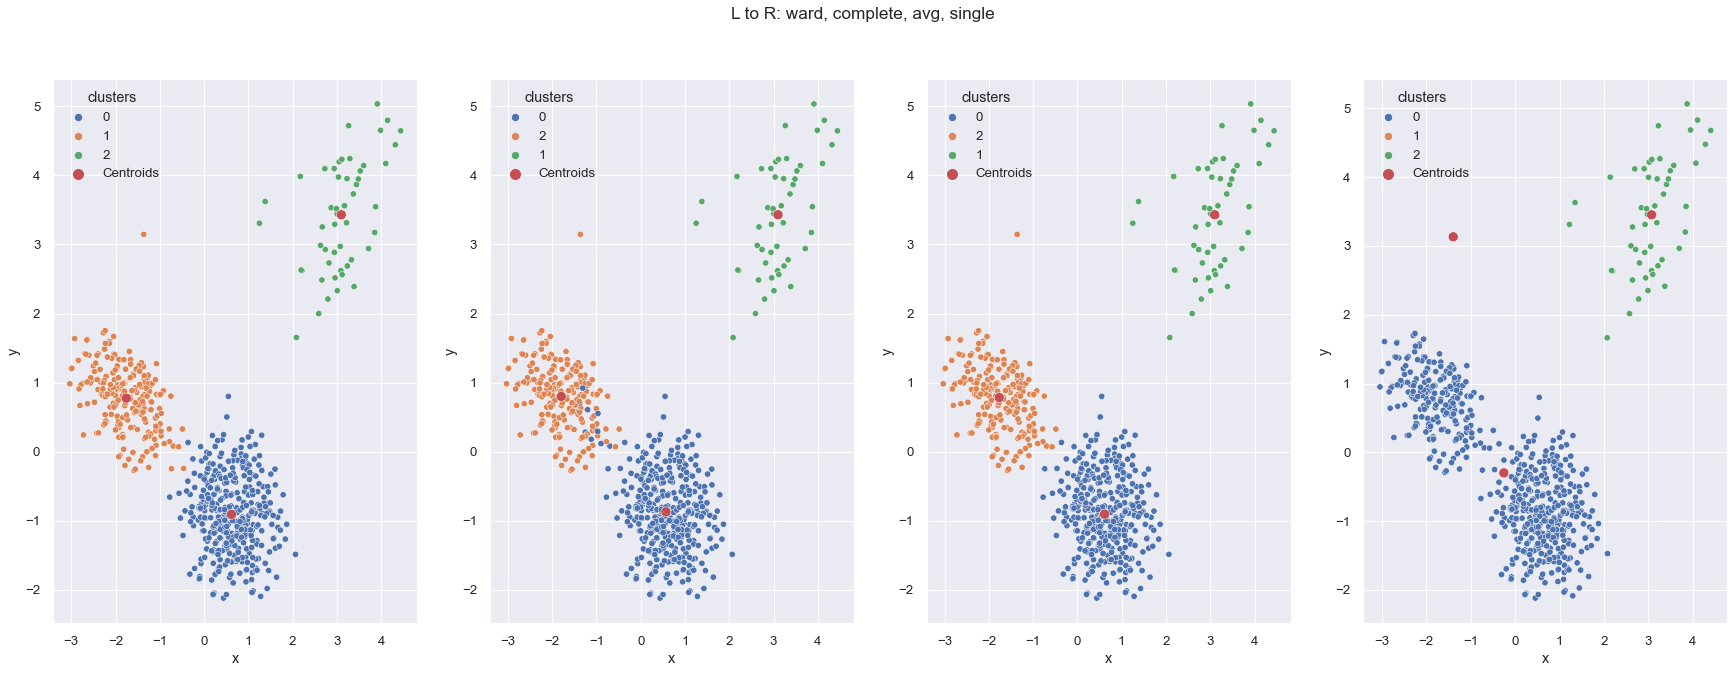

In [76]:
fig, axes = plt.subplots(1,4,figsize=(30,10))

for i, l in enumerate(linkage_methods):
    showClustersIn2D(AgglomerativeClusteringWithPredict(n_clusters=3, affinity='euclidean', linkage=l), \
            df_scaled, title=f"L to R: ward, complete, avg, single", ax=axes[i], centroid_size=100, point_size=40)

* While this is based on a 2d projection of a 5d space which may induce distortions in data spread, we note that ward and avg are very close and complete while similar has a few blue dots in the orange cluster. Single is clearly not able to cluster effectively